In [322]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [323]:
#Question
#In this assignment, you will predict the life expectancy of a newborn based on several attributes (features) related to the region which he/she was born in.

In [324]:
#Set up
life_expectancy_train_dataset = "s3://rmit-ml-2020s1-lab-data/Assignment1_data/train.csv"
life_expectancy_test_dataset = "s3://rmit-ml-2020s1-lab-data/Assignment1_data/test.csv"

In [352]:
#Pre-processing
le_train_DF = pd.read_csv(life_expectancy_train_dataset) #Training Set Dataframe
le_test_DF = pd.read_csv(life_expectancy_test_dataset) #Test Set Dataframe

#Normalise the data, using the min-max feature scaling x'= (x - min(x)) / (max(x) - min(x))
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

data_values = le_train_DF.values
data_values_scaled = min_max_scaler.fit_transform(data_values)

n_le_DF = pd.DataFrame(data_values_scaled, columns=le_train_DF.columns)
#Set X as all independent variables (minus TARGET_LifeExpectancy)
X = n_le_DF.iloc[:, :2]

#Set Y as dependent variable 'TARGET_LifeExpectancy'
Y = n_le_DF['TARGET_LifeExpectancy']

df = pd.DataFrame(X, columns=X.columns)
target = pd.DataFrame(Y)

targe

,TARGET_LifeExpectancy
0,0.537906
1,0.406137
2,0.366426
3,0.328520
4,0.368231
5,0.389892
6,0.364621
7,0.355596
8,0.463899
9,0.303249


In [307]:
# df = pd.DataFrame()

# plt.scatter(X, Y, dataFramePlot)

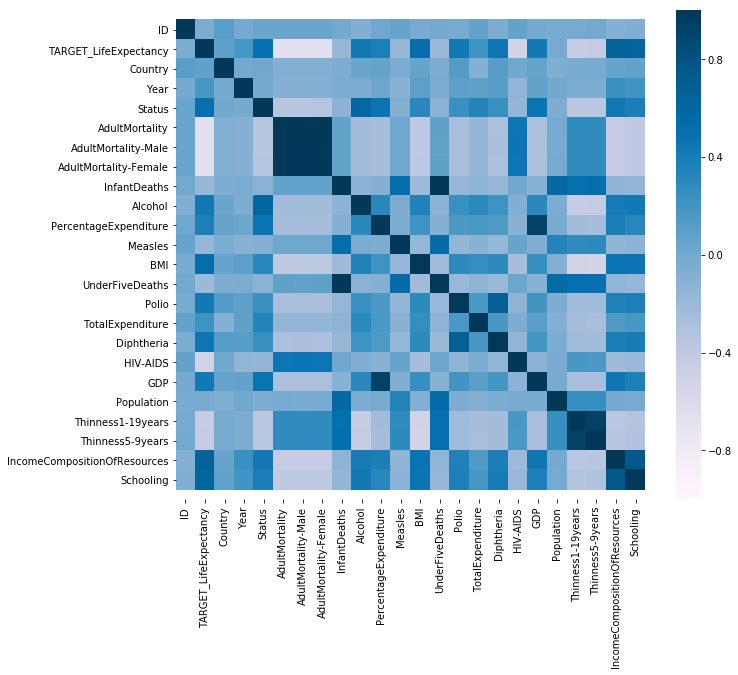

In [309]:
#Analysis

#Correlation
import seaborn as sns

correlations = n_le_DF.corr()

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(correlations, cmap="PuBu", center=0, vmin=-1, vmax=1, square=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [ ]:
#Spitting Training, Validation and Evaluation Set


In [ ]:
#Training model